# Google Marketing Metrics Validation with 2% Threshold

This notebook performs **segment-level validation** for Google Marketing Metrics data with a **2% tolerance threshold**.

**Files:**
- Target: `growth_team/marketing_matrics_google.csv`
- Gold: `marketing_metrics_google_gold.xlsx`

**Column Mapping:**
- CSV: `Day`, `Campaign`, `Cost`, `Impr.`, `Clicks`
- Gold: `date`, `campaign_name`, `spend_cost`, `impressions`, `clicks`

**Validation Segments:**
- Overall Totals
- By Date
- By Campaign

## Configuration: Set Threshold

In [1]:
# CONFIGURATION: Set your threshold here
THRESHOLD_PERCENT = 2.0  # Accept differences up to 2%

print("="*80)
print("GOOGLE MARKETING METRICS VALIDATION CONFIGURATION")
print("="*80)
print(f"\nThreshold: {THRESHOLD_PERCENT}%")
print(f"Differences under {THRESHOLD_PERCENT}% will be marked as MATCHED")
print("\nYou can change THRESHOLD_PERCENT above to adjust tolerance")

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import base64
from io import BytesIO

GOOGLE MARKETING METRICS VALIDATION CONFIGURATION

Threshold: 2.0%
Differences under 2.0% will be marked as MATCHED

You can change THRESHOLD_PERCENT above to adjust tolerance


## Step 1: Import Libraries

In [2]:
# Install openpyxl if needed
import sys
!{sys.executable} -m pip install openpyxl -q

import pandas as pd
import numpy as np
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ Libraries imported successfully")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported successfully
Analysis started: 2025-12-20 09:38:38


## Step 2: Load and Prepare Data

In [3]:
# Load Target CSV (skip first 2 metadata rows)
print("Loading Target CSV...")
growth_df = pd.read_csv("growth_team/marketing_matrics_google.csv", skiprows=2)

# Rename columns to standard names
growth_df.columns = growth_df.columns.str.strip()
growth_df.rename(columns={
    'Day': 'Day',
    'Campaign': 'Campaign name',
    'Cost': 'Cost',
    'Impr.': 'Impressions',
    'Clicks': 'Clicks'
}, inplace=True)

# Clean numeric columns (remove commas)
for col in ['Cost', 'Impressions', 'Clicks']:
    if growth_df[col].dtype == 'object':
        growth_df[col] = growth_df[col].str.replace(',', '')
    growth_df[col] = pd.to_numeric(growth_df[col], errors='coerce').fillna(0)

# Convert Day to string format for consistent comparison
growth_df['Day'] = pd.to_datetime(growth_df['Day'], dayfirst=True).dt.strftime('%Y-%m-%d')

print(f"✓ Target loaded: {len(growth_df):,} rows")
print(f"  Columns: {growth_df.columns.tolist()}")

# Load Gold Excel
print("\nLoading Gold Excel...")
gold_df = pd.read_excel("marketing_metrics_google_gold.xlsx")

# Normalize column names
gold_df.columns = gold_df.columns.str.strip()
# Rename to match target structure (CORRECTED: spend_cost not cost)
gold_df.rename(columns={
    'date': 'Day',
    'campaign_name': 'Campaign name',
    'spend_cost': 'Cost',
    'impressions': 'Impressions',
    'clicks': 'Clicks'
}, inplace=True)

# Convert Day to string format for consistent comparison
gold_df['Day'] = pd.to_datetime(gold_df['Day'], dayfirst=True).dt.strftime('%Y-%m-%d')

print(f"✓ Gold loaded: {len(gold_df):,} rows")
print(f"  Columns: {gold_df.columns.tolist()}")

print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)
print(f"\nTarget Date Range: {growth_df['Day'].min()} to {growth_df['Day'].max()}")
print(f"Gold Date Range: {gold_df['Day'].min()} to {gold_df['Day'].max()}")
print(f"\nTarget Unique Campaigns: {growth_df['Campaign name'].nunique()}")
print(f"Gold Unique Campaigns: {gold_df['Campaign name'].nunique()}")
print(f"\nTarget Campaign List: {sorted(growth_df['Campaign name'].unique())}")
print(f"\nGold Campaign List: {sorted(gold_df['Campaign name'].unique())}")

Loading Target CSV...
✓ Target loaded: 163 rows
  Columns: ['Day', 'Campaign name', 'Currency code', 'Cost', 'Impressions', 'Clicks', 'Unnamed: 6', '401869.13']

Loading Gold Excel...
✓ Gold loaded: 1,632 rows
  Columns: ['Day', 'Campaign name', 'Cost', 'Clicks', 'Impressions', 'Unnamed: 5', 'Unnamed: 6']

DATA SUMMARY

Target Date Range: 2025-11-01 to 2025-11-30
Gold Date Range: 2025-11-01 to 2025-11-30

Target Unique Campaigns: 7
Gold Unique Campaigns: 7

Target Campaign List: ['Cadiveu_Instamart_External_20th_Nov_2025', 'IKONIC-AMZ-Glide-Peach-14-Oct-2025', 'ME_Search_|_Oct_25', 'Me_Sales_P-Max_Oct25', 'Nykaa_Black_Friday_Traffic', 'PRO_Search_|_Oct_25', 'Pro_Sales_P-Max_Oct25']

Gold Campaign List: ['Cadiveu_Instamart_External_20th_Nov_2025', 'IKONIC-AMZ-Glide-Peach-14-Oct-2025', 'ME_Search_|_Oct_25', 'Me_Sales_P-Max_Oct25', 'Nykaa_Black_Friday_Traffic', 'PRO_Search_|_Oct_25', 'Pro_Sales_P-Max_Oct25']


## Step 3: Overall Totals Comparison

In [4]:
print("="*80)
print(f"OVERALL TOTALS COMPARISON (with {THRESHOLD_PERCENT}% threshold)")
print("="*80)

# Calculate totals
growth_totals = growth_df[['Cost', 'Impressions', 'Clicks']].sum()
gold_totals = gold_df[['Cost', 'Impressions', 'Clicks']].sum()

# Create comparison dataframe
overall_comparison = pd.DataFrame({
    'Metric': ['Cost', 'Impressions', 'Clicks'],
    'Target': [growth_totals['Cost'], growth_totals['Impressions'], growth_totals['Clicks']],
    'Gold': [gold_totals['Cost'], gold_totals['Impressions'], gold_totals['Clicks']],
})

overall_comparison['Difference'] = overall_comparison['Target'] - overall_comparison['Gold']
overall_comparison['Diff %'] = (overall_comparison['Difference'] / overall_comparison['Gold'] * 100).round(2)
overall_comparison['Match'] = overall_comparison['Diff %'].abs() <= THRESHOLD_PERCENT
overall_comparison['Status'] = overall_comparison['Match'].apply(lambda x: '✓ PASS' if x else '✗ FAIL')

display(overall_comparison)

# Summary
matches = overall_comparison['Match'].sum()
print(f"\n✓ Matches (within {THRESHOLD_PERCENT}%): {matches}/3 metrics")
if matches == 3:
    print(f"✓✓✓ ALL OVERALL TOTALS MATCH (within {THRESHOLD_PERCENT}% threshold)! ✓✓✓")
else:
    print(f"⚠ {3-matches} metric(s) exceed {THRESHOLD_PERCENT}% threshold")

OVERALL TOTALS COMPARISON (with 2.0% threshold)


,Metric,Target,Gold,Difference,Diff %,Match,Status
0,Cost,401869.13,401896.42,-27.29,-0.01,True,✓ PASS
1,Impressions,3324957.00,3324944.00,13.00,0.00,True,✓ PASS
2,Clicks,101520.00,101527.00,-7.00,-0.01,True,✓ PASS



✓ Matches (within 2.0%): 3/3 metrics
✓✓✓ ALL OVERALL TOTALS MATCH (within 2.0% threshold)! ✓✓✓


## Step 4: Validation by Date

In [5]:
print("="*80)
print(f"SEGMENT VALIDATION: BY DATE (with {THRESHOLD_PERCENT}% threshold)")
print("="*80)

# Aggregate by date
growth_by_date = growth_df.groupby('Day').agg({
    'Cost': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum'
}).reset_index()
growth_by_date.columns = ['Day', 'cost_target', 'impressions_target', 'clicks_target']

gold_by_date = gold_df.groupby('Day').agg({
    'Cost': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum'
}).reset_index()
gold_by_date.columns = ['Day', 'cost_gold', 'impressions_gold', 'clicks_gold']

# Merge and compare
date_comparison = pd.merge(growth_by_date, gold_by_date, on='Day', how='inner')

# Calculate percentage differences
date_comparison['cost_diff_pct'] = ((date_comparison['cost_target'] - date_comparison['cost_gold']) / date_comparison['cost_gold'] * 100).round(2)
date_comparison['impr_diff_pct'] = ((date_comparison['impressions_target'] - date_comparison['impressions_gold']) / date_comparison['impressions_gold'] * 100).round(2)
date_comparison['clicks_diff_pct'] = ((date_comparison['clicks_target'] - date_comparison['clicks_gold']) / date_comparison['clicks_gold'] * 100).round(2)

# Apply threshold matching
date_comparison['perfect_match'] = (
    (date_comparison['cost_diff_pct'].abs() <= THRESHOLD_PERCENT) & 
    (date_comparison['impr_diff_pct'].abs() <= THRESHOLD_PERCENT) & 
    (date_comparison['clicks_diff_pct'].abs() <= THRESHOLD_PERCENT)
)
date_comparison['status'] = date_comparison['perfect_match'].apply(lambda x: '✓ PASS' if x else '✗ FAIL')

print(f"\nTotal dates compared: {len(date_comparison)}")
print(f"✓ Matches (within {THRESHOLD_PERCENT}%): {date_comparison['perfect_match'].sum()}")
print(f"✗ Exceeds threshold: {(~date_comparison['perfect_match']).sum()}")

print("\nDetailed comparison:")
display(date_comparison[['Day', 'cost_target', 'cost_gold', 'cost_diff_pct',
                          'impressions_target', 'impressions_gold', 'impr_diff_pct',
                          'clicks_target', 'clicks_gold', 'clicks_diff_pct', 'status']].sort_values('Day'))

SEGMENT VALIDATION: BY DATE (with 2.0% threshold)

Total dates compared: 29
✓ Matches (within 2.0%): 29
✗ Exceeds threshold: 0

Detailed comparison:


,Day,cost_target,cost_gold,cost_diff_pct,impressions_target,impressions_gold,impr_diff_pct,clicks_target,clicks_gold,clicks_diff_pct,status
0,2025-11-01,10925.15,10925.15,-0.00,236435,236435,0.00,7798,7798,0.00,✓ PASS
1,2025-11-03,1096.78,1096.78,0.00,10160,10160,0.00,254,254,0.00,✓ PASS
2,2025-11-04,11854.49,11854.49,-0.00,131891,131886,0.00,3100,3100,0.00,✓ PASS
3,2025-11-05,1770.35,1770.34,0.00,20631,20629,0.01,930,930,0.00,✓ PASS
4,2025-11-06,5881.04,5881.83,-0.01,85302,85274,0.03,3149,3150,-0.03,✓ PASS
5,2025-11-07,12110.28,12113.55,-0.03,147661,147656,0.00,6123,6129,-0.10,✓ PASS
6,2025-11-08,14108.52,14108.91,-0.00,147160,147148,0.01,4239,4241,-0.05,✓ PASS
7,2025-11-09,22861.72,22876.05,-0.06,192827,192860,-0.02,6082,6091,-0.15,✓ PASS
8,2025-11-10,20059.33,20059.34,-0.00,136257,136245,0.01,2761,2761,0.00,✓ PASS
9,2025-11-11,15728.38,15728.39,-0.00,140885,140877,0.01,2570,2570,0.00,✓ PASS


## Step 5: Validation by Campaign

In [6]:
print("="*80)
print(f"SEGMENT VALIDATION: BY CAMPAIGN (with {THRESHOLD_PERCENT}% threshold)")
print("="*80)

# Aggregate by campaign
growth_by_campaign = growth_df.groupby('Campaign name').agg({
    'Cost': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum'
}).reset_index()
growth_by_campaign.columns = ['Campaign name', 'cost_target', 'impressions_target', 'clicks_target']

gold_by_campaign = gold_df.groupby('Campaign name').agg({
    'Cost': 'sum',
    'Impressions': 'sum',
    'Clicks': 'sum'
}).reset_index()
gold_by_campaign.columns = ['Campaign name', 'cost_gold', 'impressions_gold', 'clicks_gold']

# Merge and compare - USE OUTER to show ALL campaigns
campaign_comparison = pd.merge(growth_by_campaign, gold_by_campaign, on='Campaign name', how='outer', indicator=True)

# Fill NaN with 0 for campaigns only in one file
for col in ['cost_target', 'impressions_target', 'clicks_target', 'cost_gold', 'impressions_gold', 'clicks_gold']:
    campaign_comparison[col] = campaign_comparison[col].fillna(0)

# Calculate percentage differences with safe division
def safe_pct_diff(target, gold):
    if gold == 0 and target == 0:
        return 0
    elif gold == 0:
        return 999
    else:
        return round((target - gold) / gold * 100, 2)

campaign_comparison['cost_diff_pct'] = campaign_comparison.apply(
    lambda row: safe_pct_diff(row['cost_target'], row['cost_gold']), axis=1)
campaign_comparison['impr_diff_pct'] = campaign_comparison.apply(
    lambda row: safe_pct_diff(row['impressions_target'], row['impressions_gold']), axis=1)
campaign_comparison['clicks_diff_pct'] = campaign_comparison.apply(
    lambda row: safe_pct_diff(row['clicks_target'], row['clicks_gold']), axis=1)

# Apply threshold matching
campaign_comparison['perfect_match'] = (
    (campaign_comparison['cost_diff_pct'].abs() <= THRESHOLD_PERCENT) & 
    (campaign_comparison['impr_diff_pct'].abs() <= THRESHOLD_PERCENT) & 
    (campaign_comparison['clicks_diff_pct'].abs() <= THRESHOLD_PERCENT)
)
campaign_comparison['status'] = campaign_comparison['perfect_match'].apply(lambda x: '✓ PASS' if x else '✗ FAIL')

# Add source indicator
campaign_comparison['source'] = campaign_comparison['_merge'].map({
    'both': 'Both',
    'left_only': 'Target Only',
    'right_only': 'Gold Only'
})

print(f"\nTotal campaigns: {len(campaign_comparison)}")
print(f"  In both files: {(campaign_comparison['_merge'] == 'both').sum()}")
print(f"  Only in target: {(campaign_comparison['_merge'] == 'left_only').sum()}")
print(f"  Only in gold: {(campaign_comparison['_merge'] == 'right_only').sum()}")
print(f"\n✓ Matches (within {THRESHOLD_PERCENT}%): {campaign_comparison['perfect_match'].sum()}")
print(f"✗ Exceeds threshold: {(~campaign_comparison['perfect_match']).sum()}")

print("\nDetailed comparison:")
display(campaign_comparison[['Campaign name', 'source', 'cost_target', 'cost_gold', 'cost_diff_pct',
                              'impressions_target', 'impressions_gold', 'impr_diff_pct',
                              'clicks_target', 'clicks_gold', 'clicks_diff_pct', 'status']].sort_values('Campaign name'))

SEGMENT VALIDATION: BY CAMPAIGN (with 2.0% threshold)

Total campaigns: 7
  In both files: 7
  Only in target: 0
  Only in gold: 0

✓ Matches (within 2.0%): 7
✗ Exceeds threshold: 0

Detailed comparison:


,Campaign name,source,cost_target,cost_gold,cost_diff_pct,impressions_target,impressions_gold,impr_diff_pct,clicks_target,clicks_gold,clicks_diff_pct,status
0,Cadiveu_Instamart_External_20th_Nov_2025,Both,5499.50,5499.50,0.00,342,342,0.00,26,26,0.00,✓ PASS
1,IKONIC-AMZ-Glide-Peach-14-Oct-2025,Both,30429.57,30439.34,-0.03,287837,287775,0.02,10622,10625,-0.03,✓ PASS
2,ME_Search_|_Oct_25,Both,111296.43,111296.43,0.00,646629,646630,-0.00,13091,13091,0.00,✓ PASS
3,Me_Sales_P-Max_Oct25,Both,58665.01,58677.53,-0.02,950096,950106,-0.00,24400,24411,-0.05,✓ PASS
4,Nykaa_Black_Friday_Traffic,Both,3499.35,3497.10,0.06,216816,216816,0.00,16089,16075,0.09,✓ PASS
5,PRO_Search_|_Oct_25,Both,109587.92,109587.89,0.00,186906,186906,0.00,12231,12231,0.00,✓ PASS
6,Pro_Sales_P-Max_Oct25,Both,82891.35,82898.63,-0.01,1036331,1036369,-0.00,25061,25068,-0.03,✓ PASS


## Step 6: Final Summary Report

In [7]:
print("="*80)
print(f"GOOGLE MARKETING METRICS VALIDATION SUMMARY (with {THRESHOLD_PERCENT}% threshold)")
print("="*80)
print(f"\nAnalysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Create summary table
summary_data = [
    ['Overall Totals', 3, overall_comparison['Match'].sum(), 3 - overall_comparison['Match'].sum()],
    ['By Date', len(date_comparison), date_comparison['perfect_match'].sum(), 
     (~date_comparison['perfect_match']).sum()],
    ['By Campaign', len(campaign_comparison), campaign_comparison['perfect_match'].sum(), 
     (~campaign_comparison['perfect_match']).sum()]
]

summary_df = pd.DataFrame(summary_data, 
                         columns=['Segment Type', 'Total Segments', 'Matches', 'Exceeds Threshold'])
summary_df['Match %'] = (summary_df['Matches'] / summary_df['Total Segments'] * 100).round(2)

print("\n")
display(summary_df)

# Overall assessment
total_segments = summary_df['Total Segments'].sum()
total_matches = summary_df['Matches'].sum()
overall_match_pct = (total_matches / total_segments * 100)

print("\n" + "="*80)
print(f"OVERALL MATCH RATE (within {THRESHOLD_PERCENT}%): {total_matches}/{total_segments} ({overall_match_pct:.1f}%)")
print("="*80)

if overall_match_pct == 100:
    print(f"\n✓✓✓ PERFECT VALIDATION! All segments within {THRESHOLD_PERCENT}% threshold! ✓✓✓")
elif overall_match_pct >= 95:
    print(f"\n✓ EXCELLENT! {overall_match_pct:.1f}% of segments within {THRESHOLD_PERCENT}% threshold")
elif overall_match_pct >= 80:
    print(f"\n⚠ GOOD: {overall_match_pct:.1f}% within threshold. Some segments need review.")
else:
    print(f"\n⚠ ATTENTION: Only {overall_match_pct:.1f}% within {THRESHOLD_PERCENT}% threshold. Review required.")

print("\n" + "-"*80)
print("KEY INSIGHTS:")
print("-"*80)
print(f"• Threshold used: {THRESHOLD_PERCENT}%")
print(f"• Segments passing: {total_matches}/{total_segments}")
print(f"• Segments exceeding threshold: {total_segments - total_matches}")
print(f"• Target rows: {len(growth_df):,}")
print(f"• Gold rows: {len(gold_df):,}")

print("\n" + "="*80)
print("VALIDATION COMPLETE")
print("="*80)

GOOGLE MARKETING METRICS VALIDATION SUMMARY (with 2.0% threshold)

Analysis completed: 2025-12-20 09:38:39




,Segment Type,Total Segments,Matches,Exceeds Threshold,Match %
0,Overall Totals,3,3,0,100.00
1,By Date,29,29,0,100.00
2,By Campaign,7,7,0,100.00



OVERALL MATCH RATE (within 2.0%): 39/39 (100.0%)

✓✓✓ PERFECT VALIDATION! All segments within 2.0% threshold! ✓✓✓

--------------------------------------------------------------------------------
KEY INSIGHTS:
--------------------------------------------------------------------------------
• Threshold used: 2.0%
• Segments passing: 39/39
• Segments exceeding threshold: 0
• Target rows: 163
• Gold rows: 1,632

VALIDATION COMPLETE


## Step 7: Create Visual Dashboard

Generate a comprehensive 6-panel visualization dashboard.

CREATING VISUAL DASHBOARD

✓ Dashboard saved as 'validation_dashboard.png'


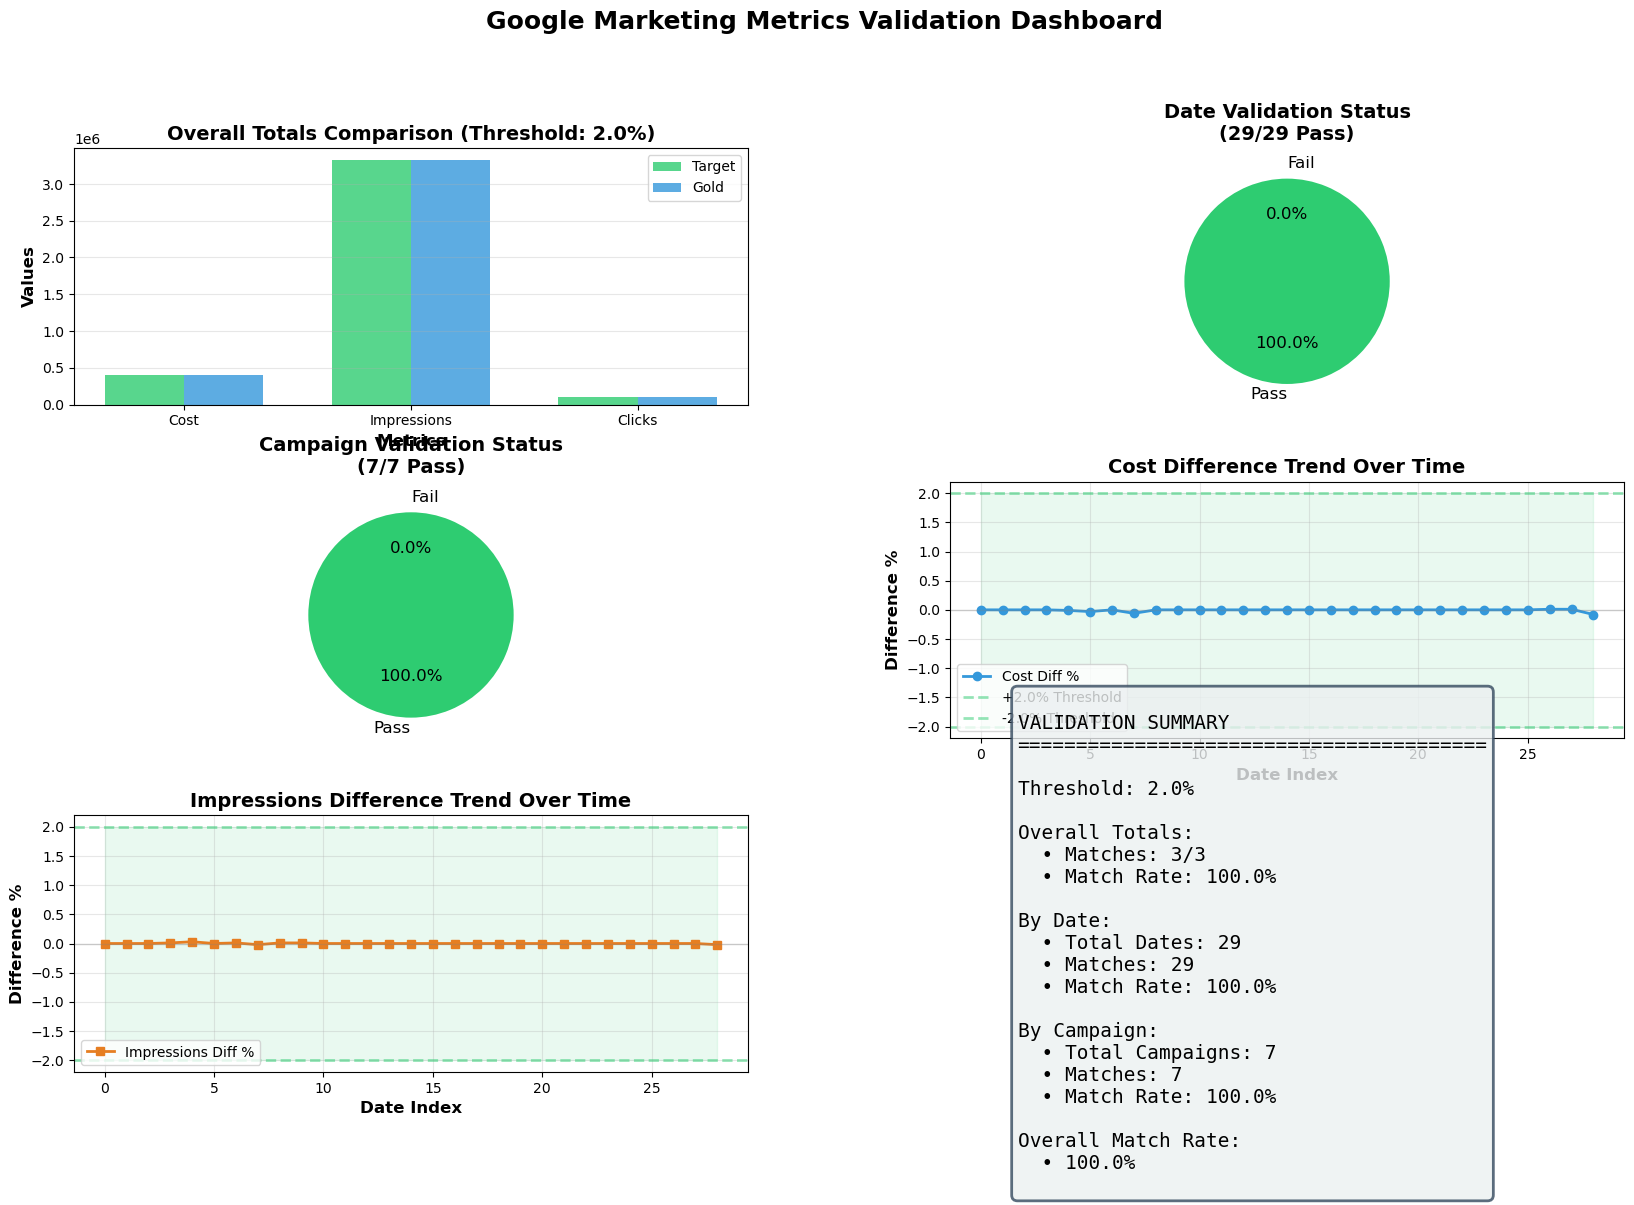


DASHBOARD CREATION COMPLETE


In [8]:
# ============================================================================
# STEP 7: CREATE VISUAL DASHBOARD
# ============================================================================
# Copy this code into a new cell in your notebook after Step 6
# ============================================================================

print("="*80)
print("CREATING VISUAL DASHBOARD")
print("="*80)

# Create figure with 6 panels
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)

# Panel 1: Overall Totals Comparison (Bar Chart)
ax1 = fig.add_subplot(gs[0, 0])
metrics = overall_comparison['Metric'].tolist()
x = range(len(metrics))
width = 0.35

colors_target = ['#2ecc71' if m else '#e74c3c' for m in overall_comparison['Match']]
colors_gold = ['#3498db'] * len(metrics)

ax1.bar([i - width/2 for i in x], overall_comparison['Target'], width, 
        label='Target', color=colors_target, alpha=0.8)
ax1.bar([i + width/2 for i in x], overall_comparison['Gold'], width, 
        label='Gold', color=colors_gold, alpha=0.8)

ax1.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax1.set_ylabel('Values', fontsize=12, fontweight='bold')
ax1.set_title(f'Overall Totals Comparison (Threshold: {THRESHOLD_PERCENT}%)', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Panel 2: Date Validation Status (Pie Chart)
ax2 = fig.add_subplot(gs[0, 1])
date_pass = date_comparison['perfect_match'].sum()
date_fail = (~date_comparison['perfect_match']).sum()

colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)
ax2.pie([date_pass, date_fail], labels=['Pass', 'Fail'], autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12})
ax2.set_title(f'Date Validation Status\n({date_pass}/{len(date_comparison)} Pass)', 
              fontsize=14, fontweight='bold')

# Panel 3: Campaign Validation Status (Pie Chart)
ax3 = fig.add_subplot(gs[1, 0])
campaign_pass = campaign_comparison['perfect_match'].sum()
campaign_fail = (~campaign_comparison['perfect_match']).sum()

ax3.pie([campaign_pass, campaign_fail], labels=['Pass', 'Fail'], autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12})
ax3.set_title(f'Campaign Validation Status\n({campaign_pass}/{len(campaign_comparison)} Pass)', 
              fontsize=14, fontweight='bold')

# Panel 4: Cost Difference Trend (Line Chart)
ax4 = fig.add_subplot(gs[1, 1])
date_sorted = date_comparison.sort_values('Day')

ax4.plot(range(len(date_sorted)), date_sorted['cost_diff_pct'], 
         marker='o', linewidth=2, markersize=6, color='#3498db', label='Cost Diff %')
ax4.axhline(y=THRESHOLD_PERCENT, color='#2ecc71', linestyle='--', 
            linewidth=2, alpha=0.5, label=f'+{THRESHOLD_PERCENT}% Threshold')
ax4.axhline(y=-THRESHOLD_PERCENT, color='#2ecc71', linestyle='--', 
            linewidth=2, alpha=0.5, label=f'-{THRESHOLD_PERCENT}% Threshold')
ax4.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.3)
ax4.fill_between(range(len(date_sorted)), -THRESHOLD_PERCENT, THRESHOLD_PERCENT, 
                 color='#2ecc71', alpha=0.1)

ax4.set_xlabel('Date Index', fontsize=12, fontweight='bold')
ax4.set_ylabel('Difference %', fontsize=12, fontweight='bold')
ax4.set_title('Cost Difference Trend Over Time', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Panel 5: Impressions Difference Trend (Line Chart)
ax5 = fig.add_subplot(gs[2, 0])

ax5.plot(range(len(date_sorted)), date_sorted['impr_diff_pct'], 
         marker='s', linewidth=2, markersize=6, color='#e67e22', label='Impressions Diff %')
ax5.axhline(y=THRESHOLD_PERCENT, color='#2ecc71', linestyle='--', 
            linewidth=2, alpha=0.5)
ax5.axhline(y=-THRESHOLD_PERCENT, color='#2ecc71', linestyle='--', 
            linewidth=2, alpha=0.5)
ax5.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.3)
ax5.fill_between(range(len(date_sorted)), -THRESHOLD_PERCENT, THRESHOLD_PERCENT, 
                 color='#2ecc71', alpha=0.1)

ax5.set_xlabel('Date Index', fontsize=12, fontweight='bold')
ax5.set_ylabel('Difference %', fontsize=12, fontweight='bold')
ax5.set_title('Impressions Difference Trend Over Time', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Panel 6: Summary Statistics (Text Box)
ax6 = fig.add_subplot(gs[2, 1])
ax6.axis('off')

summary_text = f'''
VALIDATION SUMMARY
{'='*40}

Threshold: {THRESHOLD_PERCENT}%

Overall Totals:
  • Matches: {overall_comparison['Match'].sum()}/3
  • Match Rate: {overall_comparison['Match'].sum()/3*100:.1f}%

By Date:
  • Total Dates: {len(date_comparison)}
  • Matches: {date_pass}
  • Match Rate: {date_pass/len(date_comparison)*100:.1f}%

By Campaign:
  • Total Campaigns: {len(campaign_comparison)}
  • Matches: {campaign_pass}
  • Match Rate: {campaign_pass/len(campaign_comparison)*100:.1f}%

Overall Match Rate:
  • {overall_match_pct:.1f}%
'''

ax6.text(0.1, 0.5, summary_text, fontsize=14, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', 
         facecolor='#ecf0f1', alpha=0.8, edgecolor='#34495e', linewidth=2))

# Save dashboard
plt.suptitle('Google Marketing Metrics Validation Dashboard', 
             fontsize=18, fontweight='bold', y=0.995)
plt.savefig('validation_dashboard.png', dpi=150, bbox_inches='tight')
print("\n✓ Dashboard saved as 'validation_dashboard.png'")

plt.show()

print("\n" + "="*80)
print("DASHBOARD CREATION COMPLETE")
print("="*80)


## Step 8: Export HTML Report

Generate a professional HTML report with embedded visualizations.

In [9]:
# ============================================================================
# STEP 8: EXPORT HTML REPORT
# ============================================================================
# Copy this code into a new cell in your notebook after Step 7
# IMPORTANT: Make sure you've run Step 7 first to generate the dashboard image
# ============================================================================

print("="*80)
print("EXPORTING HTML REPORT")
print("="*80)

# Read the dashboard image and convert to base64
with open('validation_dashboard.png', 'rb') as f:
    img_data = base64.b64encode(f.read()).decode()

# Create HTML report
html_content = f'''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Google Marketing Metrics Validation Report</title>
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 20px;
            min-height: 100vh;
        }}
        .container {{
            max-width: 1400px;
            margin: 0 auto;
            background: white;
            border-radius: 15px;
            box-shadow: 0 20px 60px rgba(0,0,0,0.3);
            overflow: hidden;
        }}
        .header {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 40px;
            text-align: center;
        }}
        .header h1 {{
            font-size: 2.5em;
            margin-bottom: 10px;
            text-shadow: 2px 2px 4px rgba(0,0,0,0.2);
        }}
        .header p {{
            font-size: 1.2em;
            opacity: 0.9;
        }}
        .metrics-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
            gap: 20px;
            padding: 30px;
            background: #f8f9fa;
        }}
        .metric-card {{
            background: white;
            padding: 25px;
            border-radius: 10px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            text-align: center;
            transition: transform 0.3s ease;
        }}
        .metric-card:hover {{
            transform: translateY(-5px);
            box-shadow: 0 8px 12px rgba(0,0,0,0.15);
        }}
        .metric-card h3 {{
            color: #667eea;
            font-size: 1em;
            margin-bottom: 10px;
            text-transform: uppercase;
            letter-spacing: 1px;
        }}
        .metric-card .value {{
            font-size: 2.5em;
            font-weight: bold;
            color: #2c3e50;
        }}
        .content {{
            padding: 30px;
        }}
        .section {{
            margin-bottom: 40px;
        }}
        .section h2 {{
            color: #667eea;
            font-size: 1.8em;
            margin-bottom: 20px;
            padding-bottom: 10px;
            border-bottom: 3px solid #667eea;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            margin-top: 15px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }}
        th {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 15px;
            text-align: left;
            font-weight: 600;
            text-transform: uppercase;
            font-size: 0.9em;
            letter-spacing: 0.5px;
        }}
        td {{
            padding: 12px 15px;
            border-bottom: 1px solid #ecf0f1;
        }}
        tr:hover {{
            background-color: #f8f9fa;
        }}
        .pass {{
            color: #27ae60;
            font-weight: bold;
        }}
        .fail {{
            color: #e74c3c;
            font-weight: bold;
        }}
        .dashboard-img {{
            width: 100%;
            border-radius: 10px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            margin: 20px 0;
        }}
        .footer {{
            background: #2c3e50;
            color: white;
            text-align: center;
            padding: 20px;
            font-size: 0.9em;
        }}
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>📊 Google Marketing Metrics Validation Report</h1>
            <p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p>Threshold: {THRESHOLD_PERCENT}%</p>
        </div>
        
        <div class="metrics-grid">
            <div class="metric-card">
                <h3>Overall Match Rate</h3>
                <div class="value">{overall_match_pct:.1f}%</div>
            </div>
            <div class="metric-card">
                <h3>Dates Matched</h3>
                <div class="value">{date_pass}/{len(date_comparison)}</div>
            </div>
            <div class="metric-card">
                <h3>Campaigns Matched</h3>
                <div class="value">{campaign_pass}/{len(campaign_comparison)}</div>
            </div>
            <div class="metric-card">
                <h3>Threshold</h3>
                <div class="value">±{THRESHOLD_PERCENT}%</div>
            </div>
        </div>
        
        <div class="content">
            <div class="section">
                <h2>📈 Visual Dashboard</h2>
                <img src="data:image/png;base64,{img_data}" class="dashboard-img" alt="Validation Dashboard">
            </div>
            
            <div class="section">
                <h2>📊 Overall Totals Comparison</h2>
                <table>
                    <tr>
                        <th>Metric</th>
                        <th>Target</th>
                        <th>Gold</th>
                        <th>Difference</th>
                        <th>Diff %</th>
                        <th>Status</th>
                    </tr>
'''

for _, row in overall_comparison.iterrows():
    status_class = 'pass' if row['Match'] else 'fail'
    html_content += f'''
                    <tr>
                        <td>{row['Metric']}</td>
                        <td>{row['Target']:,.2f}</td>
                        <td>{row['Gold']:,.2f}</td>
                        <td>{row['Difference']:,.2f}</td>
                        <td>{row['Diff %']:.2f}%</td>
                        <td class="{status_class}">{row['Status']}</td>
                    </tr>
'''

html_content += '''
                </table>
            </div>
            
            <div class="section">
                <h2>📅 Validation by Date (Top 20)</h2>
                <table>
                    <tr>
                        <th>Date</th>
                        <th>Cost Target</th>
                        <th>Cost Gold</th>
                        <th>Cost Diff %</th>
                        <th>Status</th>
                    </tr>
'''

for _, row in date_comparison.sort_values('Day').head(20).iterrows():
    status_class = 'pass' if row['perfect_match'] else 'fail'
    html_content += f'''
                    <tr>
                        <td>{row['Day']}</td>
                        <td>{row['cost_target']:,.2f}</td>
                        <td>{row['cost_gold']:,.2f}</td>
                        <td>{row['cost_diff_pct']:.2f}%</td>
                        <td class="{status_class}">{row['status']}</td>
                    </tr>
'''

html_content += '''
                </table>
            </div>
            
            <div class="section">
                <h2>🎯 Validation by Campaign</h2>
                <table>
                    <tr>
                        <th>Campaign</th>
                        <th>Source</th>
                        <th>Cost Target</th>
                        <th>Cost Gold</th>
                        <th>Cost Diff %</th>
                        <th>Status</th>
                    </tr>
'''

for _, row in campaign_comparison.sort_values('Campaign name').iterrows():
    status_class = 'pass' if row['perfect_match'] else 'fail'
    html_content += f'''
                    <tr>
                        <td>{row['Campaign name']}</td>
                        <td>{row['source']}</td>
                        <td>{row['cost_target']:,.2f}</td>
                        <td>{row['cost_gold']:,.2f}</td>
                        <td>{row['cost_diff_pct']:.2f}%</td>
                        <td class="{status_class}">{row['status']}</td>
                    </tr>
'''

html_content += f'''
                </table>
            </div>
            
            <div class="section">
                <h2>📋 Summary</h2>
                <table>
                    <tr>
                        <th>Segment Type</th>
                        <th>Total Segments</th>
                        <th>Matches</th>
                        <th>Exceeds Threshold</th>
                        <th>Match %</th>
                    </tr>
'''

for _, row in summary_df.iterrows():
    html_content += f'''
                    <tr>
                        <td>{row['Segment Type']}</td>
                        <td>{row['Total Segments']}</td>
                        <td>{row['Matches']}</td>
                        <td>{row['Exceeds Threshold']}</td>
                        <td>{row['Match %']:.2f}%</td>
                    </tr>
'''

html_content += f'''
                </table>
            </div>
        </div>
        
        <div class="footer">
            <p>Google Marketing Metrics Validation Report | Generated with Python & Pandas</p>
            <p>Threshold: ±{THRESHOLD_PERCENT}% | Overall Match Rate: {overall_match_pct:.1f}%</p>
        </div>
    </div>
</body>
</html>
'''

# Save HTML report
with open('validation_report.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print("\n✓ HTML report saved as 'validation_report.html'")
print("\n" + "="*80)
print("HTML EXPORT COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  • validation_dashboard.png")
print("  • validation_report.html")
print("\nOpen 'validation_report.html' in your browser to view the complete report!")


EXPORTING HTML REPORT

✓ HTML report saved as 'validation_report.html'

HTML EXPORT COMPLETE

Generated files:
  • validation_dashboard.png
  • validation_report.html

Open 'validation_report.html' in your browser to view the complete report!
